In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo
import lcl
import metpy.calc.kinematics as kine

import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
import warnings; warnings.filterwarnings("ignore")

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]

hourly_file = 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy')

In [4]:
# selecting hourly data
wrf_hourly = path + hourly_file
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

In [5]:
# retrieving SST
sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask, drop=False).values; 

In [6]:
lat = ds_hourly.nav_lat
lon = ds_hourly.nav_lon

In [8]:
U

<xarray.Dataset>
Dimensions:            (time_counter: 233, bnds: 2, y_grid_U: 546, x_grid_U: 574, lev_M: 39)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 2020-02-01T01:30:00 ... ...
    nav_lon_grid_U     (y_grid_U, x_grid_U) float32 ...
    nav_lat_grid_U     (y_grid_U, x_grid_U) float32 ...
  * lev_M              (lev_M) float32 1.0 2.0 3.0 4.0 ... 36.0 37.0 38.0 39.0
Dimensions without coordinates: bnds, y_grid_U, x_grid_U
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] ...
    U                  (time_counter, lev_M, y_grid_U, x_grid_U) float32 ...
Attributes: (12/107)
    CDI:                             Climate Data Interface version 2.0.4 (ht...
    Conventions:                     CF-1.6
    name:                            OUTPUT/2019/M06/wrfout_3h_avg_Y2019M06
    description:                     wrf M grid variables
    title:                           wrf M grid variables
    timeStamp:                       2022-Nov-03 23:29:26 GMT
    ...                              ...
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    history:                         Wed Apr 17 15:07:08 2024: cdo selvar,U f...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    CDO:                             Climate Data Operators version 2.0.4 (ht...

In [9]:
# retrievng daily wind

U = xr.open_dataset(wrf_files[files_ls.index('U.nc')]); U = U.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))
V = xr.open_dataset(wrf_files[files_ls.index('V.nc')]); V = V.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))

# sfc winds
U, V = U.U[:,0,:,:], V.V[:,0,:,:]
U, V = U.groupby('time_counter.day').mean(), V.groupby('time_counter.day').mean()

dx, dy = ds_hourly.attrs['DX'], ds_hourly.attrs['DY']


In [10]:
# time, y, x

#U,V = U.where(sea_mask, drop=False), V.where(sea_mask, drop=False)

#  divergence!

div_U = np.zeros_like(sst_day)

for x in lon.x: 
    div_U[:,:,x] = (U[:,:,x+1]-U[:,:,x])/dx 
    
for y in lat.y:
    div_U[:,y,:] = div_U[:,y,:] + (V[:,y+1,:]-V[:,y,:])/dy


#div_U = div_U.where(sea_mask, drop=False)

AttributeError: 'numpy.ndarray' object has no attribute 'where'

In [11]:
nans = np.empty_like(div_U); nans[:] = np.nan
div_U = np.where(sea_mask>0, div_U, nans)

In [ ]:
# ALTERNATIVE METHOD!!!
div_U_alt   = kine.h_convergence(U,V,dx,dy)

In [ ]:
# interestingly : VORTICITY!
v_vorticity = kine.v_vorticity(U,V,dx,dy)

In [18]:
div_U.shape

(29, 546, 573)

In [17]:
# compute anomalies daily data
s = 100

dsst_day = np.zeros(sst_day.shape)

for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)                             
    dsst_day[t] = sst_day[t] - sst_ave

0
10
20


In [25]:
# PERC DISTRIBUTION div_U vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
popmean = 0

'''pdist_div_U_day = np.zeros((div_U_day.shape[1],nbins))
pstd_div_U_day = np.zeros((div_U_day.shape[1],nbins))
pstderr_div_U_day = np.zeros((div_U_day.shape[1],nbins))
pvalue_div_U_day_sub = np.zeros((div_U_day.shape[1],nbins))
pvalue_div_U_day = np.zeros_like(pvalue_div_U_day_sub)'''

x = dsst_day.copy(); control = x.reshape(-1)
y = div_U.copy(); variable = y.reshape(-1)
    
##### Perc bin distribution: pvalue
pdist_dsst_day, pdist_div_U, pstd_div_U, pstderr_div_U, pvalue_div_U = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)

In [26]:
# FB DISTRIBUTION div_U vs dSST bin - DAILY + PVALUE subsampled
perc_step = 5
nbins = int(100/perc_step) # Number of bins
popmean = 0

'''dist_div_U = np.zeros((div_U.shape[1],nbins))
npoint_div_U = np.zeros((div_U.shape[1],nbins))
stderr_div_U = np.zeros((div_U.shape[1],nbins))
pvalue_div_U = np.zeros((div_U.shape[1],nbins))'''


x = dsst_day.copy(); control = x.reshape(-1)
y = div_U.copy(); variable = y.reshape(-1)
    
##### Fixed bin distribution: 
dist_dsst_day, dist_div_U, stderr_div_U, npoint_div_U, pv = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)


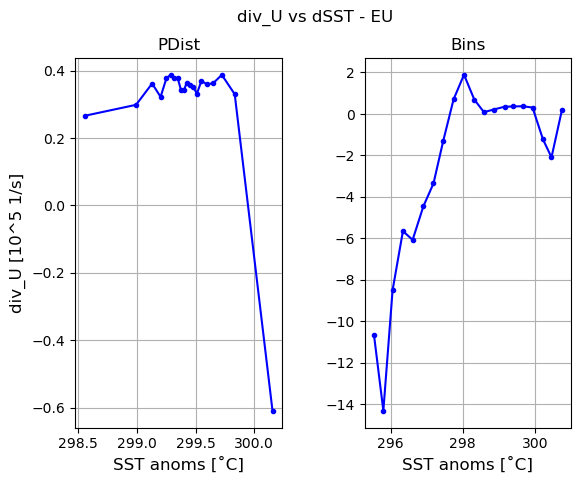

In [27]:
# $\nabla \cdot U$

fig, ax = plt.subplots(1,2)

# PERCENTILES
ax[0].plot(pdist_dsst_day, pdist_div_U*(10**5), '.-',color='b', label='PBLH')
ax[0].set_ylabel('div_U [10^5 1/s]', fontsize=12); ax[0].set_xlabel('SST anoms [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist')


# FIXED BINS
ax[1].plot(dist_dsst_day, dist_div_U*(10**5), '.-',color='b', label='PBLH')
ax[1].set_xlabel('SST anoms [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins')


fig.suptitle('div_U vs dSST - EU')

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)


#plt.savefig('/venus/tesi_ale/img_EU/distribuzioni_divergenza_dsst.png')